In [2]:
import numpy as np
import torch as torch
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt

### Training

In [3]:
device = "cuda:1"

In [5]:
def trainer(model, gener, iters, opt, loss_fn, verbose= True, non_lin = False, device= "cuda:1"):
    for i in tqdm(range(iters), desc = 'tqdm() Progress Bar'):
        (X, Y) = gener.com_get(64)
        preds= model(torch.tensor(X, device = device, dtype= torch.float32), non_lin = non_lin)
        loss= loss_fn(preds.transpose(1, 2), torch.tensor(Y, device = device))

        loss.backward()
        opt.step()
        opt.zero_grad()

        if i % 5000 == 0 and verbose:
            print("step %i: loss = %f"%(i, loss.detach().cpu().numpy()))

    print("final loss= %f"%(loss.detach().cpu().numpy()))
    

class MultiHeadAttention_wOhead(nn.Module):
    def __init__(self, seq_len, input_dim, embed_dim, attn_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0
        
        self.embed= nn.Linear(input_dim, embed_dim, bias = False)
        self.P = nn.Parameter(torch.randn(seq_len, embed_dim), requires_grad= True)
        self.key = nn.Linear(embed_dim, attn_dim, bias = False)
        self.query = nn.Linear(embed_dim, attn_dim, bias = False)
        self.value = nn.Linear(embed_dim, attn_dim, bias = False)

        self.n_head = num_heads
        self.seq_len = seq_len
        self.input_dim= input_dim
        self.emd_dim = embed_dim
        self.attn_dim = attn_dim

    def forward(self, input, non_lin = True):
        N, S, E = input.shape
        assert (S, E) == (self.seq_len, self.input_dim), "Wrong input!"

        X = self.embed(input) + self.P

        Q = torch.reshape(self.query(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1 , 2)
        K = torch.reshape(self.key(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1, 2)
        V = torch.reshape(self.value(X), (N, self.seq_len, self.n_head, self.attn_dim//self.n_head)).transpose(1, 2)
        scores= torch.matmul(Q, torch.transpose(K, 3, 2))/(self.attn_dim//self.n_head)**0.5
        
        if non_lin:
            scores= torch.softmax(scores, dim = 3)
        
        Y1 = torch.matmul(scores, V).transpose(1, 2).reshape(N, self.seq_len, self.attn_dim)
        out_att = Y1 + input

        return out_att
    
    
class sort():
    def __init__(self, leng, ran):
        self.len = leng
        self.ran= ran

    def get(self, num_swaps, b):
        sorted_seq = np.sort(np.random.choice(self.ran, [b, self.len]))
        seq = np.copy(sorted_seq)
        for _ in np.arange(num_swaps):
            i = np.random.randint(self.len-1, size= (b,))
            t= seq[np.arange(b), i]
            seq[np.arange(b), i] = seq[np.arange(b), i+1]
            seq[np.arange(b), i+1] = t
        seq = np.diag(np.ones(self.ran))[seq]

        return seq, sorted_seq
    
    def com_get(self, b):
        seq= np.random.choice(self.ran, [b, self.len])
        sorted_seq = np.sort(seq)
        seq = np.diag(np.ones(self.ran))[seq]
        
        return seq, sorted_seq

#### SA

In [21]:
lr = 1e-3
tran = MultiHeadAttention_wOhead(20, 200, 256, 200, 8)
tran.to(device= device)
gener= sort(20, 200)
opt = torch.optim.Adam(tran.parameters(), lr= lr)
loss_fn = nn.CrossEntropyLoss()
trainer(tran, gener, 250000, opt, loss_fn, verbose= True, non_lin= True)

tqdm() Progress Bar:   0%|                                                                                                                                                 | 74/250000 [00:00<11:09, 373.13it/s]

step 0: loss = 5.248956


tqdm() Progress Bar:   2%|██▉                                                                                                                                            | 5053/250000 [00:12<10:29, 389.03it/s]

step 5000: loss = 1.726644


tqdm() Progress Bar:   4%|█████▋                                                                                                                                        | 10066/250000 [00:25<10:02, 398.55it/s]

step 10000: loss = 1.384123


tqdm() Progress Bar:   6%|████████▌                                                                                                                                     | 15063/250000 [00:37<09:28, 413.08it/s]

step 15000: loss = 1.189151


tqdm() Progress Bar:   8%|███████████▍                                                                                                                                  | 20077/250000 [00:50<09:18, 411.70it/s]

step 20000: loss = 0.960081


tqdm() Progress Bar:  10%|██████████████▏                                                                                                                               | 25039/250000 [01:02<09:39, 388.27it/s]

step 25000: loss = 0.910370


tqdm() Progress Bar:  12%|█████████████████                                                                                                                             | 30064/250000 [01:15<08:59, 407.31it/s]

step 30000: loss = 0.807845


tqdm() Progress Bar:  14%|███████████████████▉                                                                                                                          | 35070/250000 [01:28<08:56, 400.48it/s]

step 35000: loss = 0.750978


tqdm() Progress Bar:  16%|██████████████████████▊                                                                                                                       | 40059/250000 [01:40<08:25, 415.52it/s]

step 40000: loss = 0.721811


tqdm() Progress Bar:  18%|█████████████████████████▌                                                                                                                    | 45082/250000 [01:53<08:38, 394.99it/s]

step 45000: loss = 0.705828


tqdm() Progress Bar:  20%|████████████████████████████▍                                                                                                                 | 50061/250000 [02:05<08:07, 410.46it/s]

step 50000: loss = 0.584439


tqdm() Progress Bar:  22%|███████████████████████████████▎                                                                                                              | 55059/250000 [02:18<08:04, 402.07it/s]

step 55000: loss = 0.600718


tqdm() Progress Bar:  24%|██████████████████████████████████                                                                                                            | 60061/250000 [02:31<08:30, 372.16it/s]

step 60000: loss = 0.627617


tqdm() Progress Bar:  26%|████████████████████████████████████▉                                                                                                         | 65046/250000 [02:43<08:22, 368.12it/s]

step 65000: loss = 0.615129


tqdm() Progress Bar:  28%|███████████████████████████████████████▊                                                                                                      | 70078/250000 [02:56<07:45, 386.75it/s]

step 70000: loss = 0.558826


tqdm() Progress Bar:  30%|██████████████████████████████████████████▋                                                                                                   | 75078/250000 [03:09<07:03, 412.72it/s]

step 75000: loss = 0.510263


tqdm() Progress Bar:  32%|█████████████████████████████████████████████▍                                                                                                | 80050/250000 [03:21<06:53, 411.26it/s]

step 80000: loss = 0.549535


tqdm() Progress Bar:  34%|████████████████████████████████████████████████▎                                                                                             | 85049/250000 [03:34<06:45, 406.56it/s]

step 85000: loss = 0.510207


tqdm() Progress Bar:  36%|███████████████████████████████████████████████████▏                                                                                          | 90054/250000 [03:46<06:38, 401.84it/s]

step 90000: loss = 0.543022


tqdm() Progress Bar:  38%|██████████████████████████████████████████████████████                                                                                        | 95080/250000 [03:59<06:15, 412.14it/s]

step 95000: loss = 0.503603


tqdm() Progress Bar:  40%|████████████████████████████████████████████████████████▍                                                                                    | 100054/250000 [04:12<06:21, 393.51it/s]

step 100000: loss = 0.499326


tqdm() Progress Bar:  42%|███████████████████████████████████████████████████████████▏                                                                                 | 105043/250000 [04:24<05:53, 410.44it/s]

step 105000: loss = 0.527478


tqdm() Progress Bar:  44%|██████████████████████████████████████████████████████████████                                                                               | 110080/250000 [04:37<05:39, 411.53it/s]

step 110000: loss = 0.493536


tqdm() Progress Bar:  46%|████████████████████████████████████████████████████████████████▉                                                                            | 115058/250000 [04:49<06:31, 344.57it/s]

step 115000: loss = 0.818359


tqdm() Progress Bar:  48%|███████████████████████████████████████████████████████████████████▋                                                                         | 120056/250000 [05:02<05:20, 405.22it/s]

step 120000: loss = 0.420183


tqdm() Progress Bar:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 125065/250000 [05:14<05:10, 402.60it/s]

step 125000: loss = 0.605640


tqdm() Progress Bar:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 130067/250000 [05:27<04:53, 408.21it/s]

step 130000: loss = 0.506916


tqdm() Progress Bar:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 135065/250000 [05:40<04:49, 397.19it/s]

step 135000: loss = 0.465565


tqdm() Progress Bar:  56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 140047/250000 [05:52<04:28, 409.93it/s]

step 140000: loss = 0.714963


tqdm() Progress Bar:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 145037/250000 [06:05<04:20, 403.22it/s]

step 145000: loss = 0.462421


tqdm() Progress Bar:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 150052/250000 [06:18<04:01, 413.14it/s]

step 150000: loss = 1.588335


tqdm() Progress Bar:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 155079/250000 [06:30<03:56, 400.76it/s]

step 155000: loss = 0.435387


tqdm() Progress Bar:  64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 160053/250000 [06:43<03:44, 400.81it/s]

step 160000: loss = 0.437465


tqdm() Progress Bar:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 165067/250000 [06:55<03:33, 398.09it/s]

step 165000: loss = 0.461632


tqdm() Progress Bar:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 170069/250000 [07:08<03:24, 390.46it/s]

step 170000: loss = 0.454287


tqdm() Progress Bar:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 175062/250000 [07:20<03:04, 406.64it/s]

step 175000: loss = 0.447278


tqdm() Progress Bar:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 180081/250000 [07:33<02:49, 411.42it/s]

step 180000: loss = 0.520593


tqdm() Progress Bar:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 185047/250000 [07:45<02:43, 397.83it/s]

step 185000: loss = 0.573123


tqdm() Progress Bar:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 190057/250000 [07:58<02:25, 410.76it/s]

step 190000: loss = 0.466468


tqdm() Progress Bar:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 195061/250000 [08:10<02:13, 411.62it/s]

step 195000: loss = 0.444604


tqdm() Progress Bar:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 200064/250000 [08:23<02:01, 412.19it/s]

step 200000: loss = 0.774721


tqdm() Progress Bar:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 205069/250000 [08:36<01:58, 378.36it/s]

step 205000: loss = 0.457598


tqdm() Progress Bar:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 210067/250000 [08:49<01:38, 406.12it/s]

step 210000: loss = 0.444004


tqdm() Progress Bar:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 215062/250000 [09:02<01:28, 396.29it/s]

step 215000: loss = 0.424804


tqdm() Progress Bar:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 220073/250000 [09:14<01:18, 380.44it/s]

step 220000: loss = 0.393771


tqdm() Progress Bar:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 225047/250000 [09:27<01:01, 407.58it/s]

step 225000: loss = 0.452492


tqdm() Progress Bar:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 230077/250000 [09:40<00:47, 421.72it/s]

step 230000: loss = 0.388319


tqdm() Progress Bar:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 235081/250000 [09:53<00:39, 377.64it/s]

step 235000: loss = 0.412808


tqdm() Progress Bar:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 240073/250000 [10:06<00:24, 403.99it/s]

step 240000: loss = 0.373192


tqdm() Progress Bar:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 245057/250000 [10:18<00:11, 413.95it/s]

step 245000: loss = 0.388086


tqdm() Progress Bar: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [10:31<00:00, 395.88it/s]

final loss= 0.405138


In [23]:
with torch.no_grad():
    (X, Y) = gener.com_get(10000)
    preds= tran(torch.tensor(X, device = device, dtype= torch.float32), non_lin = True)
    preds= torch.argmax(preds, dim = 2).detach().cpu().numpy()

    print(np.sum(1*(Y == preds))/2e5)

0.913965


In [24]:
torch.save({"model": tran.state_dict(),
            "opt": opt.state_dict()}, "/home/mahdi/sorting_softmax.tar")

#### LSA

In [5]:
lr = 5e-4
tran = MultiHeadAttention_wOhead(20, 200, 256, 200, 8)
tran.to(device= device)
gener= sort(20, 200)
opt = torch.optim.Adam(tran.parameters(), lr= lr)
loss_fn = nn.CrossEntropyLoss()
trainer(tran, gener, 250000, opt, loss_fn, verbose= True)

tqdm() Progress Bar:   0%|                                                                                                                                                | 21/250000 [00:00<1:32:49, 44.88it/s]

step 0: loss = 5.556806


tqdm() Progress Bar:   2%|██▉                                                                                                                                            | 5076/250000 [00:18<11:13, 363.69it/s]

step 5000: loss = 0.757345


tqdm() Progress Bar:   4%|█████▋                                                                                                                                        | 10061/250000 [00:33<12:55, 309.58it/s]

step 10000: loss = 0.564191


tqdm() Progress Bar:   6%|████████▌                                                                                                                                     | 15054/250000 [00:49<11:36, 337.38it/s]

step 15000: loss = 0.520469


tqdm() Progress Bar:   8%|███████████▍                                                                                                                                  | 20069/250000 [01:05<10:36, 361.04it/s]

step 20000: loss = 0.480714


tqdm() Progress Bar:  10%|██████████████▏                                                                                                                               | 25033/250000 [01:22<12:19, 304.08it/s]

step 25000: loss = 0.366243


tqdm() Progress Bar:  12%|█████████████████                                                                                                                             | 30031/250000 [01:39<10:16, 356.86it/s]

step 30000: loss = 0.423359


tqdm() Progress Bar:  14%|███████████████████▉                                                                                                                          | 35061/250000 [01:56<13:16, 269.96it/s]

step 35000: loss = 0.306983


tqdm() Progress Bar:  16%|██████████████████████▊                                                                                                                       | 40058/250000 [02:14<10:40, 327.94it/s]

step 40000: loss = 0.327703


tqdm() Progress Bar:  18%|█████████████████████████▌                                                                                                                    | 45060/250000 [02:31<11:57, 285.44it/s]

step 45000: loss = 0.339156


tqdm() Progress Bar:  20%|████████████████████████████▍                                                                                                                 | 50014/250000 [02:47<11:30, 289.67it/s]

step 50000: loss = 0.379870


tqdm() Progress Bar:  22%|███████████████████████████████▎                                                                                                              | 55056/250000 [03:04<10:42, 303.55it/s]

step 55000: loss = 0.425458


tqdm() Progress Bar:  24%|██████████████████████████████████                                                                                                            | 60034/250000 [03:23<13:13, 239.37it/s]

step 60000: loss = 0.230427


tqdm() Progress Bar:  26%|████████████████████████████████████▉                                                                                                         | 65059/250000 [03:41<08:11, 376.01it/s]

step 65000: loss = 0.264728


tqdm() Progress Bar:  28%|███████████████████████████████████████▊                                                                                                      | 70044/250000 [03:58<10:25, 287.80it/s]

step 70000: loss = 0.210338


tqdm() Progress Bar:  30%|██████████████████████████████████████████▋                                                                                                   | 75051/250000 [04:14<08:42, 335.09it/s]

step 75000: loss = 0.274458


tqdm() Progress Bar:  32%|█████████████████████████████████████████████▍                                                                                                | 80064/250000 [04:32<09:14, 306.22it/s]

step 80000: loss = 0.226420


tqdm() Progress Bar:  34%|████████████████████████████████████████████████▎                                                                                             | 85058/250000 [04:50<08:49, 311.75it/s]

step 85000: loss = 0.258276


tqdm() Progress Bar:  36%|███████████████████████████████████████████████████▏                                                                                          | 90053/250000 [05:08<11:00, 242.04it/s]

step 90000: loss = 0.198222


tqdm() Progress Bar:  38%|█████████████████████████████████████████████████████▉                                                                                        | 95047/250000 [05:26<09:59, 258.57it/s]

step 95000: loss = 0.239816


tqdm() Progress Bar:  40%|████████████████████████████████████████████████████████▍                                                                                    | 100031/250000 [05:45<10:00, 249.94it/s]

step 100000: loss = 0.194247


tqdm() Progress Bar:  42%|███████████████████████████████████████████████████████████▏                                                                                 | 105027/250000 [06:02<09:37, 250.99it/s]

step 105000: loss = 0.287359


tqdm() Progress Bar:  44%|██████████████████████████████████████████████████████████████                                                                               | 110052/250000 [06:19<06:46, 344.26it/s]

step 110000: loss = 0.187438


tqdm() Progress Bar:  46%|████████████████████████████████████████████████████████████████▉                                                                            | 115043/250000 [06:38<06:48, 330.32it/s]

step 115000: loss = 0.244502


tqdm() Progress Bar:  48%|███████████████████████████████████████████████████████████████████▋                                                                         | 120050/250000 [06:55<07:47, 278.25it/s]

step 120000: loss = 0.386156


tqdm() Progress Bar:  50%|██████████████████████████████████████████████████████████████████████▌                                                                      | 125069/250000 [07:13<06:00, 346.93it/s]

step 125000: loss = 0.275081


tqdm() Progress Bar:  52%|█████████████████████████████████████████████████████████████████████████▎                                                                   | 130031/250000 [07:29<06:26, 310.13it/s]

step 130000: loss = 0.196898


tqdm() Progress Bar:  54%|████████████████████████████████████████████████████████████████████████████▏                                                                | 135057/250000 [07:46<06:21, 301.12it/s]

step 135000: loss = 0.197510


tqdm() Progress Bar:  56%|██████████████████████████████████████████████████████████████████████████████▉                                                              | 140040/250000 [08:03<06:16, 291.82it/s]

step 140000: loss = 0.188957


tqdm() Progress Bar:  58%|█████████████████████████████████████████████████████████████████████████████████▊                                                           | 145020/250000 [08:21<07:14, 241.38it/s]

step 145000: loss = 0.196536


tqdm() Progress Bar:  60%|████████████████████████████████████████████████████████████████████████████████████▋                                                        | 150063/250000 [08:38<04:56, 337.20it/s]

step 150000: loss = 0.209358


tqdm() Progress Bar:  62%|███████████████████████████████████████████████████████████████████████████████████████▍                                                     | 155048/250000 [08:55<04:50, 326.78it/s]

step 155000: loss = 0.212006


tqdm() Progress Bar:  64%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 160030/250000 [09:13<05:46, 259.40it/s]

step 160000: loss = 0.169359


tqdm() Progress Bar:  66%|█████████████████████████████████████████████████████████████████████████████████████████████                                                | 165051/250000 [09:30<05:32, 255.14it/s]

step 165000: loss = 0.158774


tqdm() Progress Bar:  68%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 170048/250000 [09:48<04:04, 326.87it/s]

step 170000: loss = 0.174893


tqdm() Progress Bar:  70%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 175041/250000 [10:06<05:06, 244.50it/s]

step 175000: loss = 0.258354


tqdm() Progress Bar:  72%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 180031/250000 [10:23<04:12, 277.01it/s]

step 180000: loss = 0.213560


tqdm() Progress Bar:  74%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 185054/250000 [10:40<03:48, 284.72it/s]

step 185000: loss = 0.437736


tqdm() Progress Bar:  76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 190015/250000 [10:58<03:18, 302.57it/s]

step 190000: loss = 0.141220


tqdm() Progress Bar:  78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 195055/250000 [11:16<02:57, 310.22it/s]

step 195000: loss = 0.201808


tqdm() Progress Bar:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 200042/250000 [11:33<03:26, 241.64it/s]

step 200000: loss = 0.306179


tqdm() Progress Bar:  82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 205036/250000 [11:51<02:08, 348.86it/s]

step 205000: loss = 0.455426


tqdm() Progress Bar:  84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 210025/250000 [12:08<02:14, 296.48it/s]

step 210000: loss = 1.040469


tqdm() Progress Bar:  86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 215040/250000 [12:24<02:47, 208.88it/s]

step 215000: loss = 0.130160


tqdm() Progress Bar:  88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 220039/250000 [12:42<01:38, 305.11it/s]

step 220000: loss = 0.194181


tqdm() Progress Bar:  90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 225053/250000 [13:01<01:34, 262.77it/s]

step 225000: loss = 0.202868


tqdm() Progress Bar:  92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 230029/250000 [13:19<01:22, 243.23it/s]

step 230000: loss = 0.324065


tqdm() Progress Bar:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 235018/250000 [13:37<00:50, 298.32it/s]

step 235000: loss = 0.183936


tqdm() Progress Bar:  96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 240042/250000 [13:55<00:36, 272.48it/s]

step 240000: loss = 0.178735


tqdm() Progress Bar:  98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 245044/250000 [14:13<00:18, 263.06it/s]

step 245000: loss = 0.346191


tqdm() Progress Bar: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250000/250000 [14:32<00:00, 286.51it/s]

final loss= 0.198512


In [49]:
torch.save({"model": tran.state_dict(),
            "opt": opt.state_dict()}, "/home/mahdi/sorting.tar")

### Experiments

In [98]:
checkpoint= torch.load("./sorting.tar")
tran = MultiHeadAttention_wOhead(20, 200, 256, 200, 8)
tran.to(device= device)
tran.load_state_dict(checkpoint["model"])
gener= sort(20, 200)

In [99]:
with torch.no_grad():
    (X, Y) = gener.com_get(10000)
    preds= tran(torch.tensor(X, device = device, dtype= torch.float32), non_lin = False)
    preds= torch.argmax(preds, dim = 2).detach().cpu().numpy()

    print(np.sum(1*(Y == preds))/2e5)

0.95332


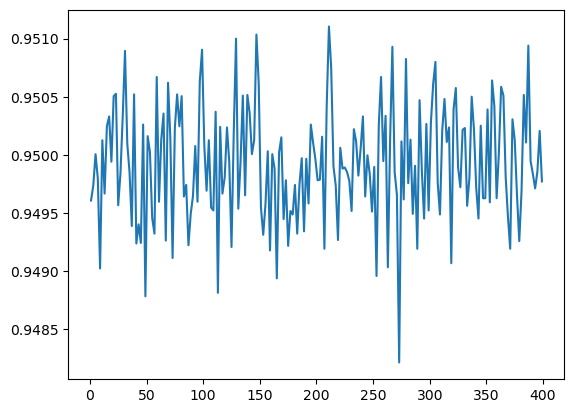

In [22]:
accs= []

with torch.no_grad():
    for swaps in range(1, 400, 2):
        (X, Y) = gener.get(100, 10000)
        preds= tran(torch.tensor(X, device = device, dtype= torch.float32), non_lin = False)
        preds= torch.argmax(preds, dim = 2).detach().cpu().numpy()

        accs.append(np.sum(1*(Y == preds))/2e5)

plt.plot(range(1, 400, 2), accs)

In [48]:
Y = np.sort(np.random.choice(200, [10000, 20]))
X = np.flip(Y, axis =1).copy()
X = np.diag(np.ones(200))[X]
preds= tran(torch.tensor(X, device = device, dtype= torch.float32), non_lin = False)
preds= torch.argmax(preds, dim = 2).detach().cpu().numpy()

print(np.sum(1*(Y == preds))/2e5)

0.95183


### What's going on inside

In [61]:
Embed= tran.embed.weight.clone().detach().cpu()
torch.save({"embedding": Embed}, "/home/mahdi/sorting_embedding.tar")

In [4]:
def get_attmap(model, gener, num_batches, non_lin):
    model.to(device = 'cpu')
    attmap= []
    sorted_attmap = []
    
    with torch.no_grad():
        for _ in range(num_batches):
            (X, _) = gener.com_get(64)
            X= torch.tensor(X, dtype= torch.float32)
            N, S, E = X.shape
            assert (S, E) == (model.seq_len, model.input_dim), "Wrong input!"

            X = model.embed(X) + model.P

            Q = torch.reshape(model.query(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1 , 2)
            K = torch.reshape(model.key(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1, 2)
            V = torch.reshape(model.value(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1, 2)
            scores= torch.matmul(Q, torch.transpose(K, 3, 2))/(model.attn_dim//model.n_head)**0.5

            if non_lin:
                scores = torch.softmax(scores, dim = 3)
            else:
                scores = torch.div(torch.abs(scores) , torch.norm(scores, p =1, dim =3, keepdim= True))

            args = torch.argsort(torch.argmax(X, dim = 2), dim =1)
            args = torch.eye(S)[args][:, None, :, :]

            sorted_scores = args @ scores @ args.mT
            attmap.append(torch.mean(torch.mean(scores, dim = 1), dim = 0))
            sorted_attmap.append(torch.mean(torch.mean(sorted_scores, dim = 1), dim = 0))
            
    attmap = torch.mean(torch.stack(attmap), dim = 0)
    sorted_attmap = torch.mean(torch.stack(sorted_attmap), dim = 0)
    
    return attmap, sorted_attmap


def get_attmap_single(model, gener, non_lin):
    model.to(device = 'cpu')
    
    with torch.no_grad():
        (X, _) = gener.com_get(1)
        X= torch.tensor(X, dtype= torch.float32)
        N, S, E = X.shape
        assert (S, E) == (model.seq_len, model.input_dim), "Wrong input!"

        X = model.embed(X) + model.P

        Q = torch.reshape(model.query(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1 , 2)
        K = torch.reshape(model.key(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1, 2)
        V = torch.reshape(model.value(X), (N, S, model.n_head, model.attn_dim//model.n_head)).transpose(1, 2)
        scores= torch.matmul(Q, torch.transpose(K, 3, 2))/(model.attn_dim//model.n_head)**0.5

        if non_lin:
            scores = torch.softmax(scores, dim = 3)
        else:
            scores = torch.div(torch.abs(scores) , torch.norm(scores, p =1, dim =3, keepdim= True))

        args = torch.argsort(torch.argmax(X, dim = 2), dim =1)
        args = torch.eye(S)[args][:, None, :, :]

        sorted_scores = args @ scores @ args.mT
        
    attmap = torch.squeeze(scores)
    sorted_attmap = torch.squeeze(sorted_scores)
            
    return attmap, sorted_attmap

#### Softmax

In [4]:
checkpoint= torch.load("./sorting_softmax.tar")
tran = MultiHeadAttention_wOhead(20, 200, 256, 200, 8)
tran.to(device= device)
tran.load_state_dict(checkpoint["model"])
gener= sort(20, 200)

NameError: name 'MultiHeadAttention_wOhead' is not defined

In [22]:
attmap, sorted_attmap = get_attmap_single(tran, gener, non_lin = True)

##### Positional attention

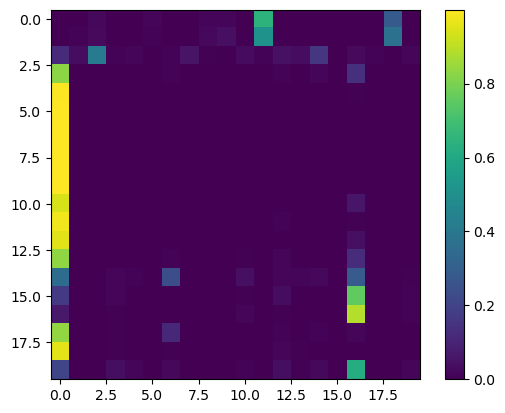

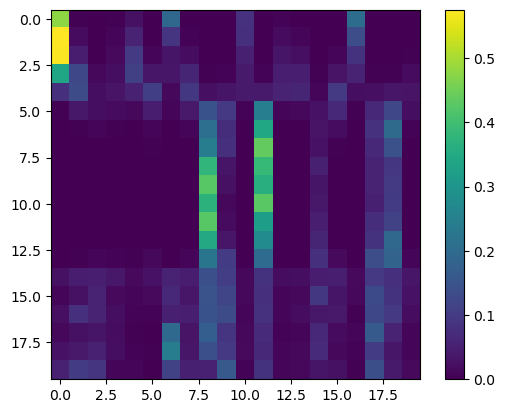

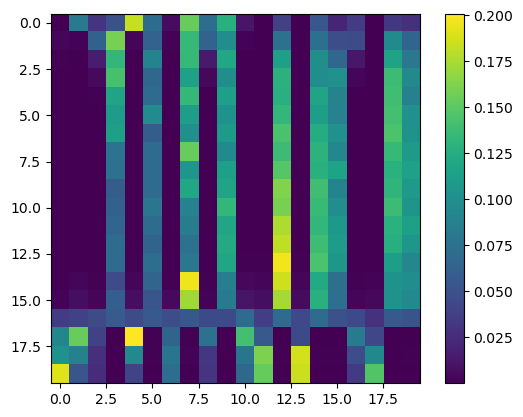

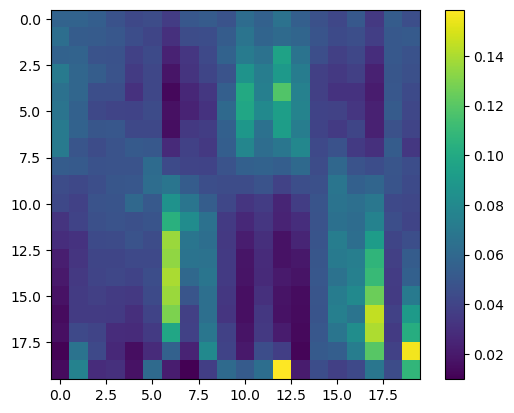

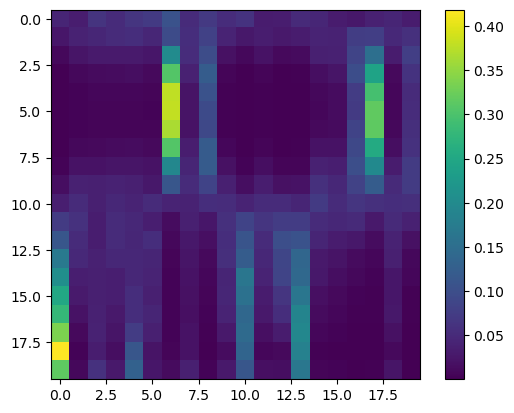

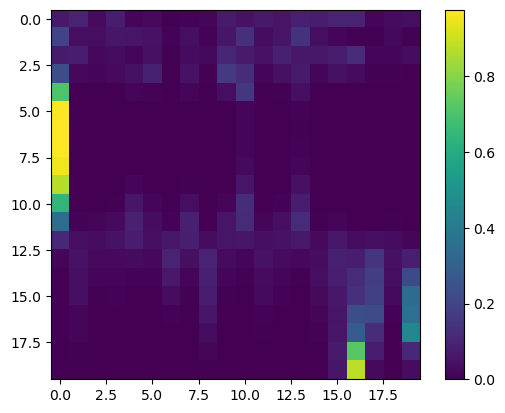

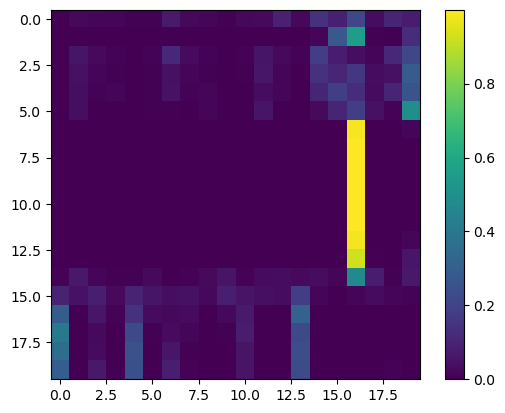

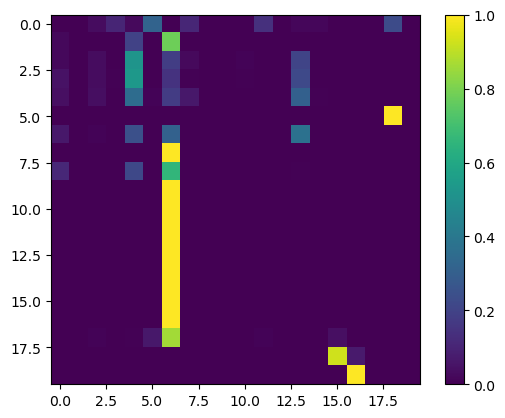

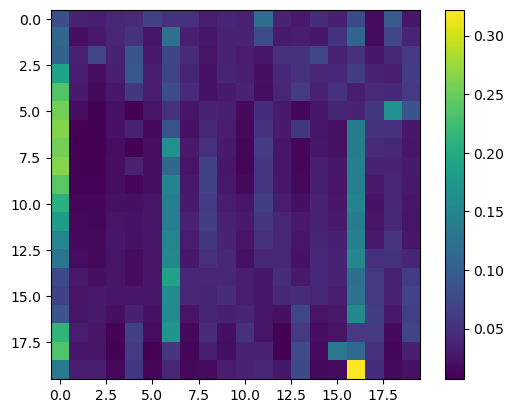

In [23]:
for i in range(attmap.shape[0]):
    plt.figure()
    im = plt.imshow(attmap[i])
    plt.colorbar(im)

plt.figure()
im = plt.imshow(torch.mean(attmap, dim = 0))
plt.colorbar(im)

##### attention respect to sorted positions

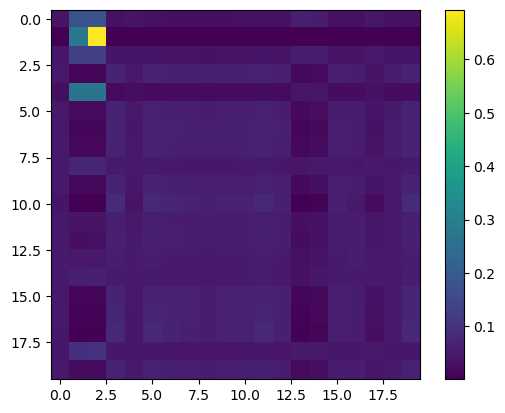

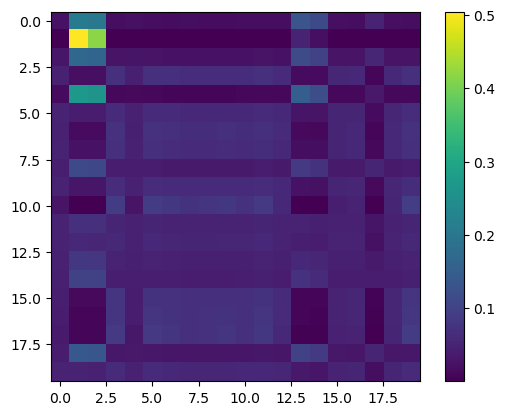

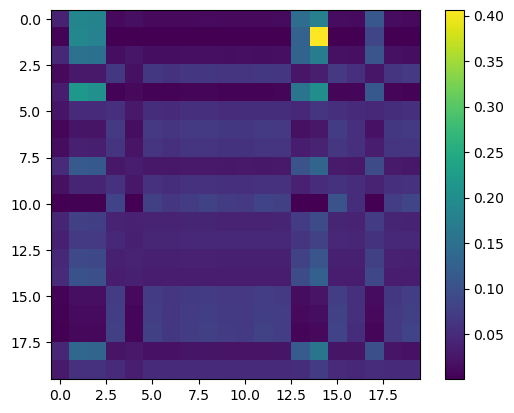

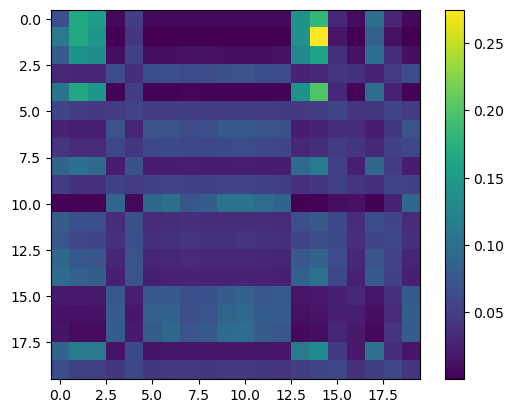

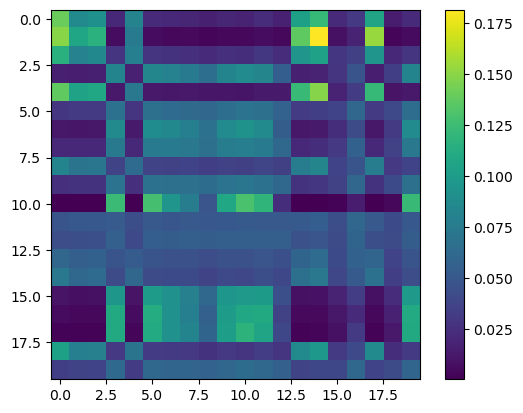

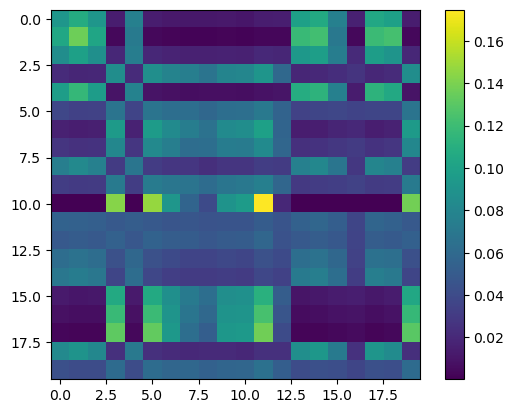

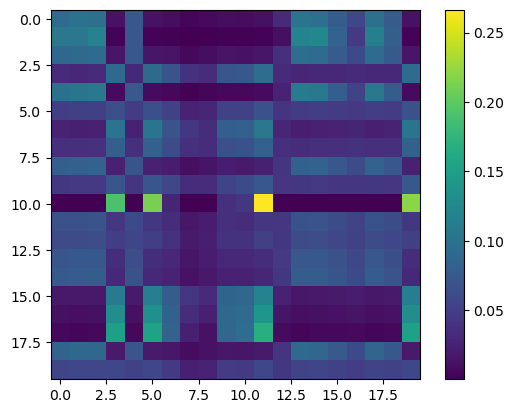

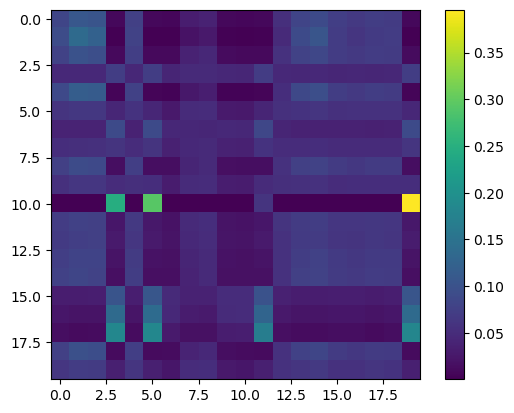

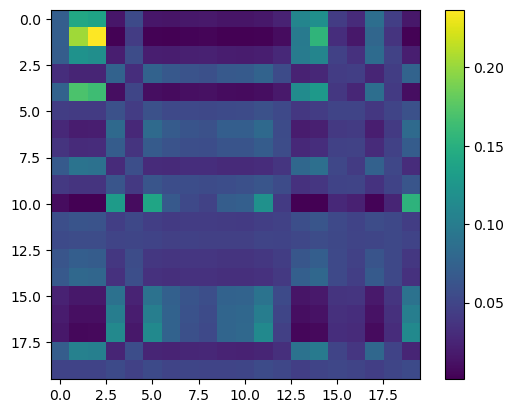

In [14]:
for i in range(sorted_attmap.shape[0]):
    plt.figure()
    im = plt.imshow(sorted_attmap[i])
    plt.colorbar(im)

plt.figure()
im = plt.imshow(torch.mean(sorted_attmap, dim = 0))
plt.colorbar(im)

#### Linear

In [6]:
checkpoint= torch.load("./sorting.tar")
tran = MultiHeadAttention_wOhead(20, 200, 256, 200, 8)
tran.to(device= device)
tran.load_state_dict(checkpoint["model"])
gener= sort(20, 200)

In [7]:
print(tran.P.s)

Parameter containing:
tensor([[-0.1106,  0.3923,  0.3525,  ...,  0.3204, -0.2015,  0.0125],
        [ 1.1197, -0.4761, -1.4451,  ...,  0.8402, -0.8857, -0.6501],
        [ 2.1402,  0.0294,  0.3606,  ...,  0.7418, -0.4546,  1.8588],
        ...,
        [ 0.2011, -0.3748, -0.7368,  ...,  0.5686, -0.1290, -0.1406],
        [ 0.1880,  1.8253, -1.0263,  ...,  1.3832,  0.5110,  1.6860],
        [ 0.0388,  0.4699, -1.4048,  ..., -0.0828, -0.1257, -0.0191]],
       device='cuda:1', requires_grad=True)


TypeError: can't convert cuda:1 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

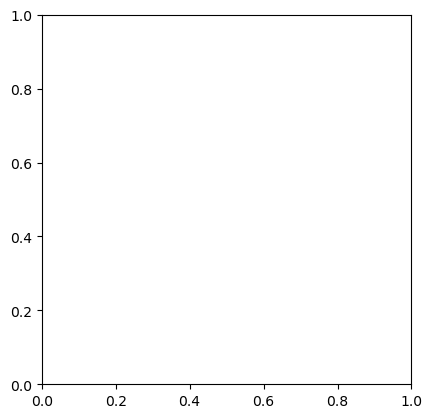

In [8]:
plt.imshow(tran.P)

In [29]:
attmap, sorted_attmap = get_attmap_single(tran, gener, non_lin = False)

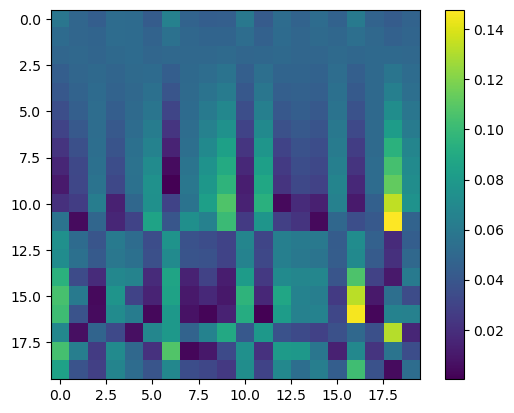

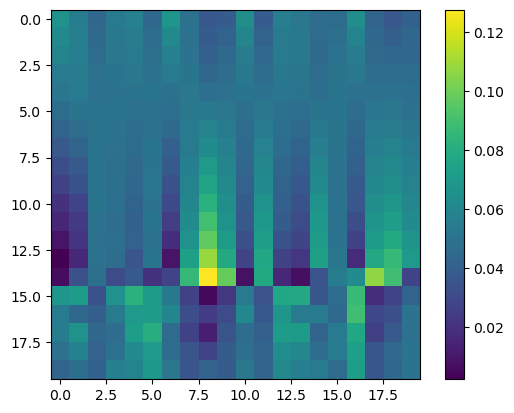

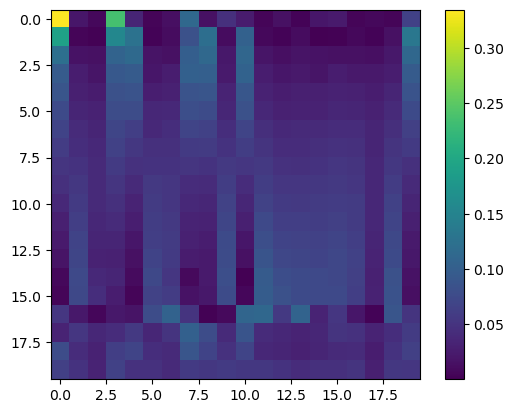

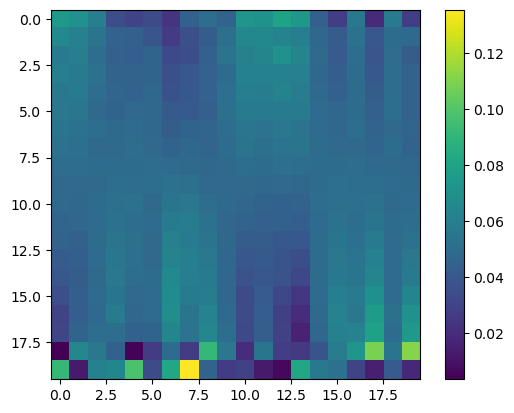

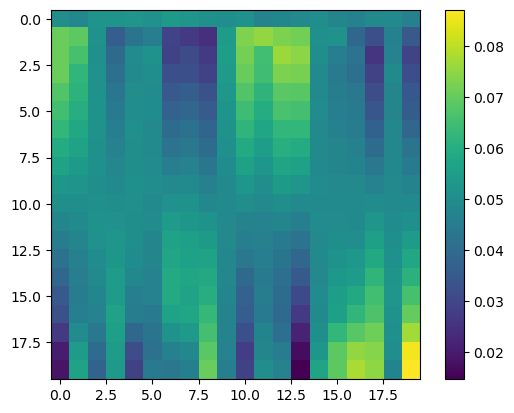

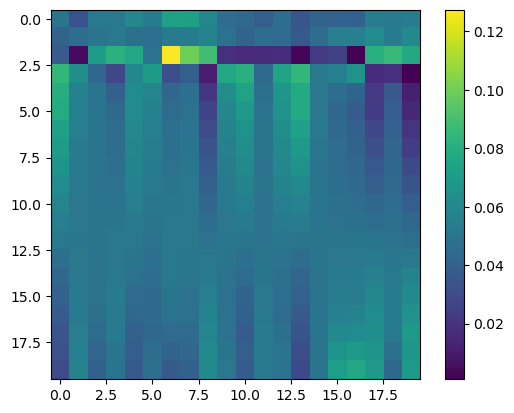

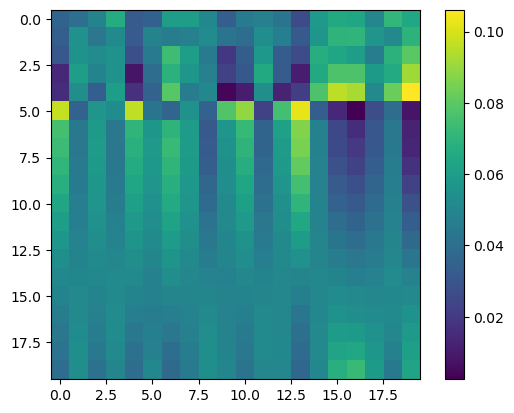

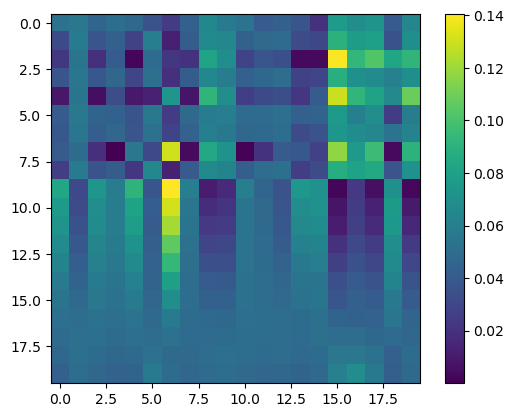

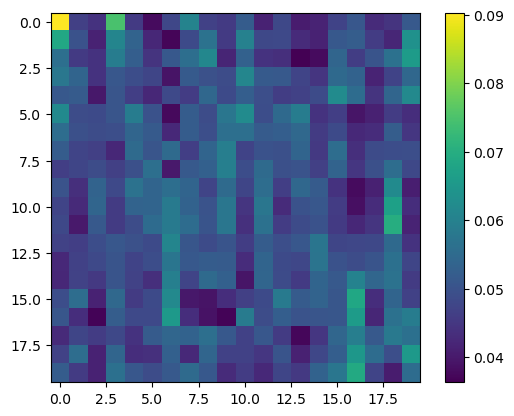

In [30]:
for i in range(attmap.shape[0]):
    plt.figure()
    im = plt.imshow(attmap[i])
    plt.colorbar(im)

plt.figure()
im = plt.imshow(torch.mean(attmap, dim = 0))
plt.colorbar(im)

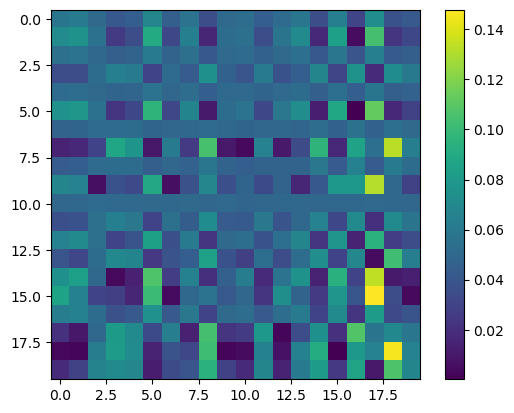

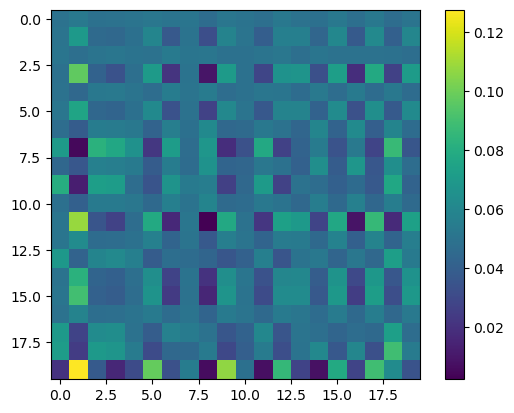

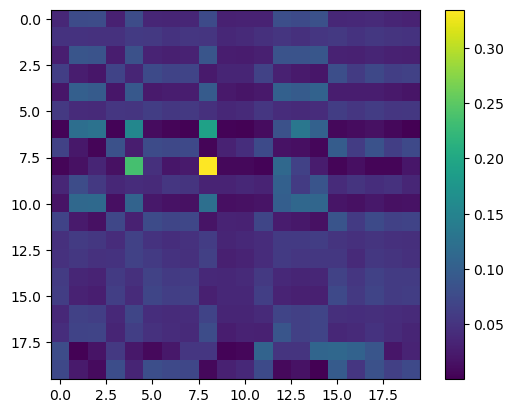

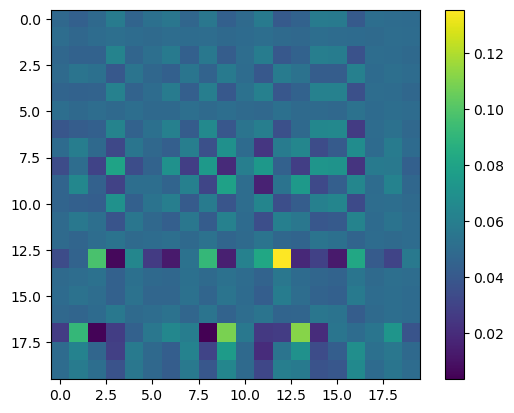

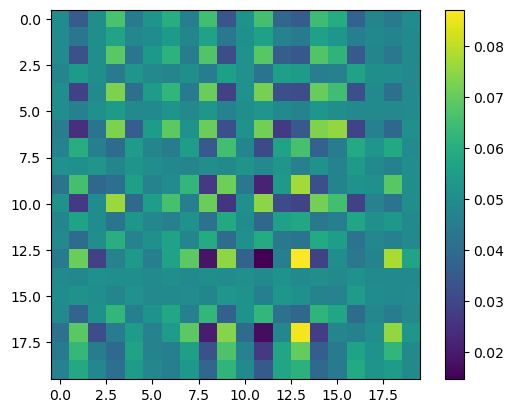

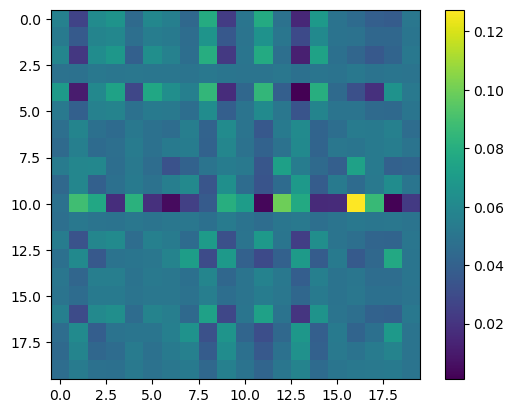

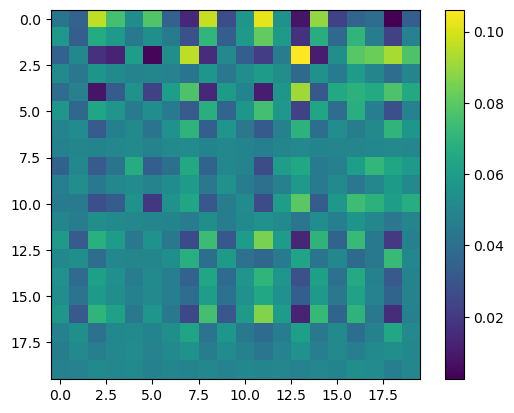

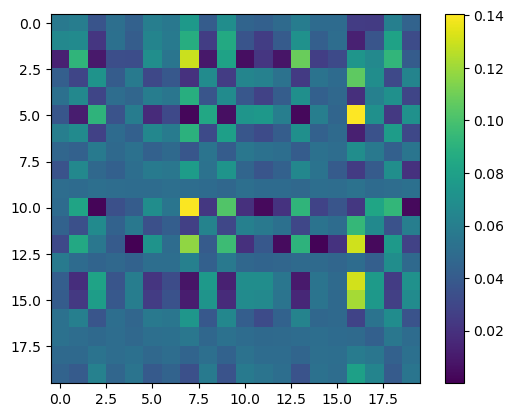

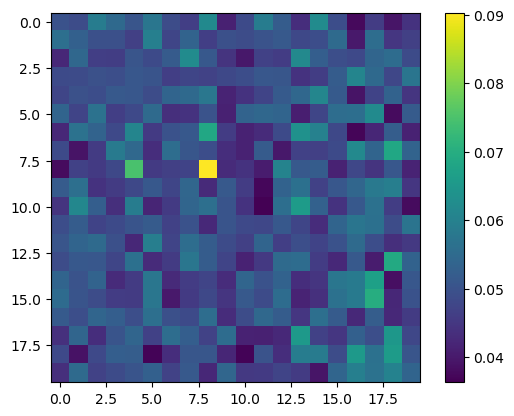

In [32]:
for i in range(sorted_attmap.shape[0]):
    plt.figure()
    im = plt.imshow(sorted_attmap[i])
    plt.colorbar(im)

plt.figure()
im = plt.imshow(torch.mean(sorted_attmap, dim = 0))
plt.colorbar(im)